# proj_01 — Healthcare: Medicine/Vaccine Demand & Shortage Risk
This notebook aligns with *Machine Learning with Python (Course 1)*. It demonstrates regression for demand forecasting and classification for shortage risk, plus validation and evaluation.

In [2]:

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import joblib
import os

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

import pathlib

# Get the project root (the folder where streamlit_app.py and notebooks live)
PROJECT_DIR = pathlib.Path(__file__).resolve().parents[1] if "__file__" in globals() else pathlib.Path(os.getcwd()) / "proj_01"

ASSETS = PROJECT_DIR / "proj_01_assets"
ASSETS.mkdir(parents=True, exist_ok=True)


In [ ]:

# --- Standardized paths for repo-friendly saves ---
from pathlib import Path
import os

# Resolve project root whether running from repo root or notebooks/
ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

DATA = ROOT / "proj_01" / "data" if (ROOT / "proj_01").exists() else ROOT / "data"
MODELS = ROOT / "proj_01" / "models" if (ROOT / "proj_01").exists() else ROOT / "models"

DATA.mkdir(parents=True, exist_ok=True)
MODELS.mkdir(parents=True, exist_ok=True)

print(f"Saving CSVs to: {DATA}")
print(f"Saving models to: {MODELS}")


In [2]:

# Matplotlib settings (default colors, single-plot rule honored in guidance)
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True


## 1) Generate Synthetic Healthcare Utilization & Inventory Data

In [3]:

# Synthetic healthcare data
np.random.seed(42)
n_hosp = 50
hospitals = [f"HOSP_{i:03d}" for i in range(n_hosp)]
regions = ["NE","SE","MW","SW","NW"]
medicines = ["FluVax","Insulin","Antibiotic","PainRelief","Antiviral","PPE_Mask"]

rows = []
for hosp in hospitals:
    region = np.random.choice(regions)
    for m in medicines:
        for month in range(1, 13):
            seasonal = {
                "FluVax": 0.6 if month in [10,11,12,1,2] else 0.2,
                "Insulin": 0.4,
                "Antibiotic": 0.5 if month in [12,1,2,3] else 0.3,
                "PainRelief": 0.3,
                "Antiviral": 0.5 if month in [12,1,2] else 0.2,
                "PPE_Mask": 0.3
            }[m]
            pop_scale = np.random.uniform(0.8,1.3)
            base_demand = np.random.randint(80, 300)
            demand = base_demand * (1 + seasonal) * pop_scale
            # region modifier
            demand *= (1 + {"NE":0.05,"SE":0.10,"MW":0.00,"SW":0.08,"NW":-0.02}[region])
            # noise
            demand += np.random.normal(0, 20)
            demand = max(10, demand)

            inventory = np.random.randint(50, 400)
            lead_time_days = np.random.choice([2,3,7,10,14,21])
            rows.append([hosp, region, m, month, int(demand), inventory, lead_time_days])

hc = pd.DataFrame(rows, columns=["Hospital","Region","Medicine","Month","Demand","Inventory","LeadTimeDays"])
hc.to_csv(DATA / "healthcare_demand.csv", index=False)
hc.head()


,Hospital,Region,Medicine,Month,Demand,Inventory,LeadTimeDays
0,HOSP_000,SW,FluVax,1,419,171,7
1,HOSP_000,SW,FluVax,2,441,137,14
2,HOSP_000,SW,FluVax,3,319,393,10
3,HOSP_000,SW,FluVax,4,347,241,10
4,HOSP_000,SW,FluVax,5,327,219,10


## 2) EDA

In [4]:

hc.describe(include='all').T.head(20)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Hospital,3600,50,HOSP_000,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Region,3600,5,NW,1080,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Medicine,3600,6,FluVax,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month,3600.0,NaN,NaN,NaN,6.5,3.452532,1.0,3.75,6.5,9.25,12.0
Demand,3600.0,NaN,NaN,NaN,274.811389,105.999068,57.0,189.0,269.0,350.0,641.0
Inventory,3600.0,NaN,NaN,NaN,222.398889,100.344933,50.0,138.0,221.0,309.0,399.0
LeadTimeDays,3600.0,NaN,NaN,NaN,9.456667,6.60431,2.0,3.0,7.0,14.0,21.0


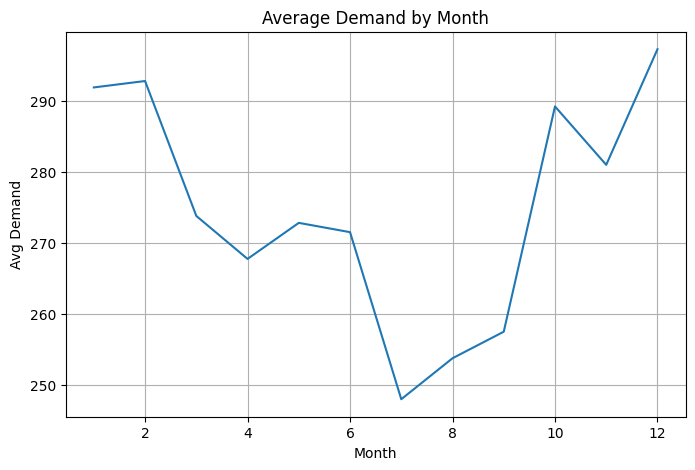

In [5]:

# Visual: Demand by Month (aggregate)
agg = hc.groupby("Month")["Demand"].mean().reset_index()
plt.figure()
plt.plot(agg["Month"], agg["Demand"])
plt.xlabel("Month"); plt.ylabel("Avg Demand"); plt.title("Average Demand by Month")
plt.show()


## 3) Regression: Predict Demand

In [6]:

X_reg = hc.drop(columns=["Demand"])
y_reg = hc["Demand"]

num_cols = ["Inventory","LeadTimeDays","Month"]
cat_cols = ["Hospital","Region","Medicine"]

prep = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

models = {
    "Linear": LinearRegression(),
    "Tree": DecisionTreeRegressor(max_depth=10, random_state=RANDOM_SEED),
    "RF": RandomForestRegressor(n_estimators=300, random_state=RANDOM_SEED)
}

Xtr, Xte, ytr, yte = train_test_split(X_reg, y_reg, test_size=0.2, random_state=RANDOM_SEED)

res = {}
for name, mdl in models.items():
    pipe = Pipeline([("prep", prep), ("mdl", mdl)]).fit(Xtr, ytr)
    pred = pipe.predict(Xte)
    mse = mean_squared_error(yte, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(yte, pred)
    res[name] = dict(RMSE=rmse, R2=r2)

pd.DataFrame(res).T


,RMSE,R2
Linear,105.796973,-0.026637
Tree,118.026107,-0.277693
RF,108.075066,-0.071325


In [7]:

best = pd.DataFrame(res).T.sort_values(by=["RMSE","R2"], ascending=[True, False]).index[0]
best_reg_pipe = Pipeline([("prep", prep), ("mdl", models[best])]).fit(Xtr, ytr)
joblib.dump(best_reg_pipe, MODELS / "healthcare_demand_model.pkl")
print("Saved:", MODELS / "healthcare_demand_model.pkl")


Saved: /content/proj_01_assets/healthcare_demand_model.pkl


## 4) Classification: Shortage Risk (Will Stockout Occur?)

In [8]:

# Define a label: stockout risk if Inventory < projected demand buffer
buffer_days = 7
daily_demand = hc["Demand"] / 30.0
risk = (hc["Inventory"] < daily_demand * buffer_days).astype(int)

X_cls = hc.drop(columns=["Demand"])
y_cls = risk

num_cols = ["Inventory","LeadTimeDays","Month"]
cat_cols = ["Hospital","Region","Medicine"]

prep_cls = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

models_cls = {
    "LogReg": LogisticRegression(max_iter=1000),
    "Tree": DecisionTreeClassifier(max_depth=8, random_state=RANDOM_SEED),
    "RF": RandomForestClassifier(n_estimators=250, random_state=RANDOM_SEED)
}

Xtr, Xte, ytr, yte = train_test_split(X_cls, y_cls, test_size=0.2, random_state=RANDOM_SEED, stratify=y_cls)

res_cls = {}
for name, mdl in models_cls.items():
    pipe = Pipeline([("prep", prep_cls), ("mdl", mdl)]).fit(Xtr, ytr)
    pred = pipe.predict(Xte)
    proba = pipe.predict_proba(Xte)[:,1]
    acc = accuracy_score(yte, pred)
    prec = precision_score(yte, pred)
    rec = recall_score(yte, pred)
    f1 = f1_score(yte, pred)
    auc = roc_auc_score(yte, proba)
    res_cls[name] = dict(accuracy=acc, precision=prec, recall=rec, f1=f1, roc_auc=auc)

pd.DataFrame(res_cls).T


,accuracy,precision,recall,f1,roc_auc
LogReg,0.956944,0.678571,0.463415,0.550725,0.971838
Tree,0.948611,0.590909,0.317073,0.412698,0.913467
RF,0.961111,0.809524,0.414634,0.548387,0.969827


Saved: /content/proj_01_assets/healthcare_shortage_model.pkl


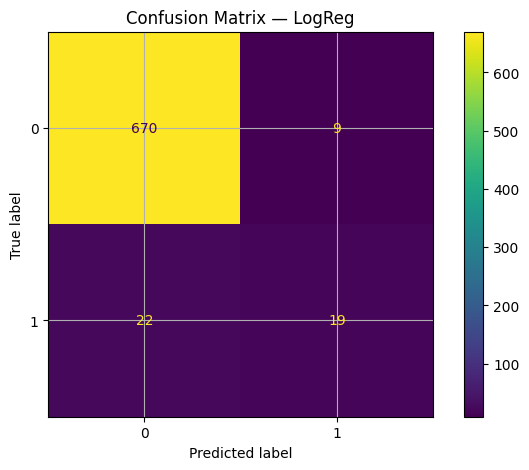

In [9]:

bestc = pd.DataFrame(res_cls).T.sort_values(by=["f1","roc_auc"], ascending=False).index[0]
best_cls_pipe = Pipeline([("prep", prep_cls), ("mdl", models_cls[bestc])]).fit(Xtr, ytr)
joblib.dump(best_cls_pipe, MODELS / "healthcare_shortage_model.pkl")
print("Saved:", MODELS / "healthcare_shortage_model.pkl")

# Confusion matrix
cm = confusion_matrix(yte, best_cls_pipe.predict(Xte))
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title(f"Confusion Matrix — {bestc}")
plt.show()
